#### Tóm tắt các bước chính:
1. Khởi tạo môi trường CartPole
2. Xây dựng mô hình A2C với 2 mạng: mạng Actor và mạng Critic (mỗi mạng gồm 2 lớp Dense)
3. Huấn luyện mô hình:
    - Với mỗi episode:
        - Khởi tạo trạng thái và điểm số
        - Với mỗi bước trong episode:
            - Lấy hành động từ mạng Actor
            - Thực hiện hành động, nhận lại trạng thái tiếp theo và điểm số
            - Tính reward cho hành động
            - Cập nhật mô hình với hành động, reward và trạng thái tiếp theo
            - Cập nhật điểm số
        - Lưu điểm số của episode
        - Vẽ biểu đồ điểm số
        - Nếu điểm số trung bình của 10 episode gần nhất lớn hơn 490 thì dừng huấn luyện
4. Lưu mô hình sau mỗi 50 episode
5. Đóng môi trường CartPole
6. Gọi hàm CartPoleCrossEntropy với số episode mặc định là 20
7. Kết quả: sau 20 episode, mô hình chưa học được cách chơi tốt, điểm số không tăng lên nhiều
    - Cần tăng số episode để mô hình học được cách chơi tốt hơn
    - Cần tinh chỉnh các siêu tham số khác để mô hình học tốt hơn
    - Cần thử các mô hình khác để so sánh hiệu suất

In [25]:
import sys
import gym
import pylab
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from collections import deque
import tensorflow as tf

import custom_loss

In [26]:
import tensorflow as tf

def cross_entropy_loss(y_true, y_pred):
    val = y_true * tf.math.log(y_pred)
    return tf.reduce_sum(-val, -1)

In [27]:
y_true = tf.constant([[0, 1, 0], [1, 0, 0]], dtype=tf.float32)
y_pred = tf.constant([[0.05, 0.95, 0], [0.1, 0.8, 0.1]], dtype=tf.float32)
loss = cross_entropy_loss(y_true, y_pred)
print(loss)

tf.Tensor([      nan 2.3025851], shape=(2,), dtype=float32)


In [28]:
# A2C(Advantage Actor-Critic) agent for the Cartpole
class A2CAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        ## 0.03 0.005 - learning rate for half faster
        self.actor_lr = 0.03
        self.critic_lr = 0.005

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model:
            self.actor.load_weights("cartpole_actor.weights.h5")
            self.critic.load_weights("cartpole_critic.weights.h5")
    
    def ce_custom_loss(self, y_true, y_pred):
        val = tf.square(y_true) * tf.math.log(y_pred) + y_true
        return tf.reduce_sum(-val, -1)

    def cross_entropy_loss(self, y_true, y_pred):
        val = y_true * tf.math.log(y_pred)
        return tf.reduce_sum(-val, -1)

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        acc = tf.keras.metrics.TopKCategoricalAccuracy(k=1, name="top_k_categorical_accuracy", dtype=None)
#self.my_loss_fn
        actor.compile(loss=self.cross_entropy_loss, optimizer=Adam(learning_rate=self.critic_lr), metrics=[acc])
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        critic.summary()
        critic.compile(loss="mse", optimizer=Adam(learning_rate=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        #print("advantages", advantages, "target", target, "adv type", type(advantages), advantages.shape)
        #advantages advantages[np.where(advantages==np.max(advantages))] = 1
        advantages = (advantages - np.min(advantages))/np.ptp(advantages)
        #print("advantages", advantages)
        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

In [29]:
DEFAULT_EPISODES = 5
def CartPoleCrossEntropy(EPISODES=DEFAULT_EPISODES):
    # In case of CartPole-v1, maximum length of episode is 500
    env = gym.make('CartPole-v1', render_mode="human")
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    print("state size: ", state_size, "action size: ", action_size)
    # make A2C agent
    agent = A2CAgent(state_size, action_size)

    scores, episodes = [], []
    scores_deque = deque(maxlen=100)

    for e in range(EPISODES):
        done = False
        score = 0
        state, _ = env.reset()
        state = np.reshape(state, [1, state_size])
        
        while not done:
            if agent.render:
                env.render()

            action = agent.get_action(state)
            next_state, reward, done, info, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100

            agent.train_model(state, action, reward, next_state, done)

            score += reward
            state = next_state

            if done:
                # every episode, plot the play time
                score = score if score == 500.0 else score + 100
                scores.append(score)
                scores_deque.append(score)

                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("cartpole_a2c.png")
                print("episode:", e, "  score:", score)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    sys.exit()
        
        # save the model
        if e % 50 == 0:
            print("saving model")
            agent.actor.save_weights("cartpole_actor.weights.h5")
            agent.critic.save_weights("cartpole_critic.weights.h5")

    env.close()

state size:  4 action size:  2
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 24)                120       
                                                                 
 dense_13 (Dense)            (None, 2)                 50        
                                                                 
Total params: 170 (680.00 Byte)
Trainable params: 170 (680.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 24)                120       
                                                                 
 dense_15 (Dense)            (None, 1)                 25        
                             

C:\Users\tiennhm\AppData\Roaming\Python\Python310\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 [==============================] - 0s 50ms/step


C:\Users\tiennhm\AppData\Local\Temp\ipykernel_8172\2680641943.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  advantages[0][action] = reward + self.discount_factor * (next_value) - value
C:\Users\tiennhm\AppData\Local\Temp\ipykernel_8172\2680641943.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target[0][0] = reward + self.discount_factor * next_value


1/1 [==============================] - 0s 34ms/step


C:\Users\tiennhm\AppData\Local\Temp\ipykernel_8172\2680641943.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  advantages[0][action] = reward - value


episode: 0   score: 46.0
saving model
1/1 [==============================] - 0s 31ms/step
episode: 1   score: 22.0
1/1 [==============================] - 0s 29ms/step
episode: 2   score: 20.0
1/1 [==============================] - 0s 42ms/step
episode: 3   score: 16.0
1/1 [==============================] - 0s 27ms/step
episode: 4   score: 29.0
1/1 [==============================] - 0s 27ms/step
episode: 5   score: 13.0
1/1 [==============================] - 0s 29ms/step
episode: 6   score: 17.0
1/1 [==============================] - 0s 34ms/step
episode: 7   score: 18.0
1/1 [==============================] - 0s 35ms/step
episode: 8   score: 9.0
1/1 [==============================] - 0s 29ms/step
episode: 9   score: 16.0
1/1 [==============================] - 0s 29ms/step
episode: 10   score: 18.0
1/1 [==============================] - 0s 29ms/step
episode: 11   score: 14.0
1/1 [==============================] - 0s 30ms/step
episode: 12   score: 23.0
1/1 [==============================]

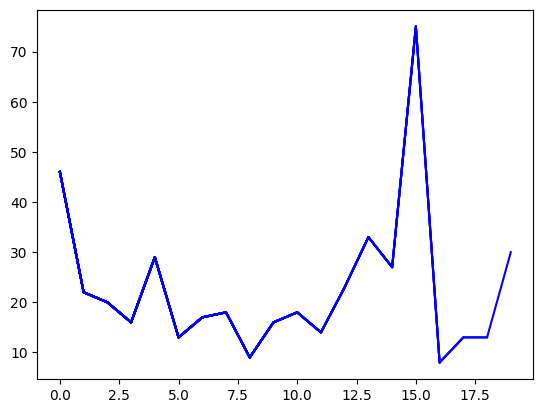

In [30]:
if __name__ == "__main__":
    CartPoleCrossEntropy(EPISODES=20)